In [1]:
###### data loader####
#import clip
from tqdm import tqdm
import numpy as np
from PIL import Image
from math import log, sqrt, pi
import argparse
from torch import nn, optim
from torch.autograd import Variable, grad
from scipy import linalg as la
from transformers import CLIPProcessor, CLIPModel
import math
import torchvision.transforms as tvt
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zipfile
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as tfms
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision.utils import make_grid
from torchvision import utils
from PIL import Image
import random
from tqdm import trange
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import confusion_matrix
import open_clip
torch.set_num_threads(5)    
torch.set_num_interop_threads(5)  


data_dir = r"../../Dataset/data/waterbirds_v1.0"
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
batch_size = 1



def get_transform_clip(train):
    transform = tfms.Compose([       
        tfms.Resize((224,224), interpolation=tfms.InterpolationMode.BICUBIC),
        tfms.ToTensor(),
        tfms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    return transform


model,_, preprocess =  open_clip.create_model_and_transforms("ViT-L-14", pretrained='laion2b_s32b_b82k') #ViTB/32
model = model.to(device)
tokenizer = open_clip.get_tokenizer('ViT-L-14')




def seed_everything(seed):
    """
    Changes the seed for reproducibility. 
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    
class ConfounderDataset_train(Dataset):
    def __init__(self, root_dir,
                 target_name, confounder_names,
                 model_type=None, augment_data=None):
        raise NotImplementedError

    def __len__(self):
        return len(self.training_sample)

    def __getitem__(self, idx):
        y = self.training_sample_y_array[idx]
        a = self.training_sample_confounder_array[idx]
        img_filename = os.path.join(
            data_dir,
            self.training_sample[idx])       
        img = preprocess(Image.open(img_filename))
        return img,y,a

    
    
class CUBDataset_train(ConfounderDataset_train):
    """
    CUB dataset (already cropped and centered).
    Note: metadata_df is one-indexed.
    """
    def __init__(self):
        self.data_dir = os.path.join(
           data_dir)

        if not os.path.exists(self.data_dir):
            raise ValueError(
                f'{self.data_dir} does not exist yet. Please generate the dataset first.')

        # Read in metadata
        self.metadata_df = pd.read_csv(
            os.path.join(self.data_dir, 'metadata.csv'))

        # Get the y values
        self.y_array = self.metadata_df['y'].values
        self.n_classes = 2

        # We only support one confounder for CUB for now
        self.confounder_array = self.metadata_df['place'].values
        self.n_confounders = 1
        
        # Extract filenames and splits
        self.filename_array = self.metadata_df['img_filename'].values
        self.split_array = self.metadata_df['split'].values

        self.training_sample = self.filename_array[self.split_array == 0]
        self.training_sample_y_array = self.y_array[self.split_array == 0]
        self.training_sample_confounder_array =self.confounder_array[self.split_array == 0]

        self.clip_transform = get_transform_clip(train=False)

class ConfounderDataset_test(Dataset):
    def __init__(self, root_dir,
                 target_name, confounder_names,
                 model_type=None, augment_data=None):
        raise NotImplementedError

    def __len__(self):
        return len(self.test_sample)

    def __getitem__(self, idx):
        y = self.test_sample_y_array[idx]
        a = self.test_sample_confounder_array[idx]
        img_filename = os.path.join(
            data_dir,
            self.test_sample[idx])       
        img = preprocess(Image.open(img_filename))

        
        return img,y,a
        
class CUBDataset_test(ConfounderDataset_test):
    """
    CUB dataset (already cropped and centered).
    Note: metadata_df is one-indexed.
    """
    def __init__(self):
        self.data_dir = os.path.join(
           data_dir,)

        if not os.path.exists(self.data_dir):
            raise ValueError(
                f'{self.data_dir} does not exist yet. Please generate the dataset first.')

        # Read in metadata
        self.metadata_df = pd.read_csv(
            os.path.join(self.data_dir, 'metadata.csv'))

        # Get the y values
        self.y_array = self.metadata_df['y'].values
        self.n_classes = 2

        # We only support one confounder for CUB for now
        self.confounder_array = self.metadata_df['place'].values
        self.n_confounders = 1
        
        # Extract filenames and splits
        self.filename_array = self.metadata_df['img_filename'].values
        self.split_array = self.metadata_df['split'].values

        self.test_sample = self.filename_array[self.split_array == 2]
        self.test_sample_y_array = self.y_array[self.split_array == 2]
        self.test_sample_confounder_array =self.confounder_array[self.split_array == 2]
        # Set transform
        self.clip_transform = get_transform_clip(train=False)





test_dataset = CUBDataset_test()


test_data_loader  = torch.utils.data.DataLoader(dataset = test_dataset,
                                                batch_size= batch_size,
                                                shuffle=False,
                                                num_workers=0,
                                                drop_last=False)
print('Done')

Done


Testing: 100%|██████████████████████████████████████████████████████████████████████| 5794/5794 [05:39<00:00, 17.06it/s]


Accuracy for label=1, sensitive=1: 0.88162 (total: 642.0)
Accuracy for label=1, sensitive=0: 0.74143 (total: 642.0)
Accuracy for label=0, sensitive=0: 0.96186 (total: 2255.0)
Accuracy for label=0, sensitive=1: 0.81685 (total: 2255.0)
Overall accuracy: 0.87211 (total: 5794)


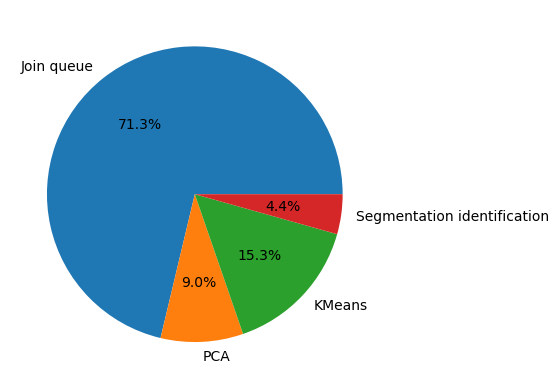

In [2]:
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import minmax_scale
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from scipy.ndimage import gaussian_filter
from sklearn.cluster import AgglomerativeClustering
from collections import deque, defaultdict
import time


queue_length = 28
segment_num = 3
pca_feature_num = 3

def pca_single_modality(pca_features, mask, n_imgs, img):  
    to_pil_image = tfms.ToPILImage()
    for i in range(3):
        pca_features[:, i] = (pca_features[:, i] - pca_features[:, i].min()) / (pca_features[:, i].max() - pca_features[:, i].min())
    plt.figure(figsize=(5, 5))
    
    for i in range(n_imgs):
        fig, ax = plt.subplots(1, 3)
        img[i] = (img[i] - img[i].min()) / (img[i].max() - img[i].min())
        image_np = to_pil_image(img[i].cpu().squeeze(0))
        ax[0].imshow(image_np)    
        print(pca_features[i*16*16 :(i+1)*16*16, :].shape)
        image_pca = torch.tensor(pca_features[i*16*16 :(i+1)*16*16, :].reshape(16,16, 3))                    
        ax[1].imshow(image_pca.cpu().numpy())
        ax[2].imshow(mask[i*16*16 :(i+1)*16*16, :].reshape(16,16, 3))
    plt.show()
    plt.close()



def pca_single_modality_queue(pca_features, mask, n_imgs, img, id, imshow = False):  
    to_pil_image = tfms.ToPILImage()
    for i in range(segment_num):
        pca_features[:, i] = (pca_features[:, i] - pca_features[:, i].min()) / (pca_features[:, i].max() - pca_features[:, i].min())

    if id < queue_length:
        image_pca = torch.tensor(pca_features[id*16*16 : (id + 1)*16*16, :].reshape(16,16, pca_feature_num))    
    else:
        image_pca = torch.tensor(pca_features[-16*16 :, :].reshape(16,16, pca_feature_num))

    if id < queue_length:
        mask_tensor = mask[id*16*16 : (id + 1)*16*16, :].reshape(16,16, segment_num)
    else:
        mask_tensor = mask[-16*16 :, :].reshape(16,16, segment_num)
    
    if imshow == True:
        plt.figure(figsize=(5, 5))
        fig, ax = plt.subplots(1, segment_num)
        img = (img - img.min()) / (img.max() - img.min())
        image_np = to_pil_image(img.cpu().squeeze(0))
        ax[0].imshow(image_np)                 
        ax[1].imshow(image_pca.cpu().numpy())
        ax[2].imshow(mask_tensor)
        plt.show()
        plt.close()
    return mask_tensor


def masked_img(image, mask, imshow, prob):  # image: (3, 224, 224), mask: (16, 16, 3)
    to_pil_image = tfms.ToPILImage()
    mask_single_channel = torch.argmax(mask, dim=-1)  # Shape: [16, 16]
    mask_upsampled = F.interpolate(mask_single_channel.unsqueeze(0).unsqueeze(0).float(),
                                    size=(224, 224), mode="nearest").squeeze().long()  # Shape: [224, 224]
    binary_masks = [(mask_upsampled == value).float() for value in range(segment_num)]
    masked_images = [image * binary_mask.unsqueeze(0) for binary_mask in binary_masks]
    normalized_images = []
    show_images = []
    for masked_image in masked_images:
        if masked_image.max() > masked_image.min():
            #normalized_image = (masked_image - masked_image.min()) / (masked_image.max() - masked_image.min())
            normalized_image = masked_image
        else:
            normalized_image = masked_image  # No normalization needed if uniform
        show_image = (masked_image - masked_image.min()) / (masked_image.max() - masked_image.min())
        normalized_images.append(normalized_image)
        show_images.append(show_image)
    if imshow == True:
        plt.figure(figsize=(10, 5))
        fig, ax = plt.subplots(1, segment_num+1)
        for i in range(segment_num):
            image_np = to_pil_image(show_images[i].squeeze(0).cpu())
            ax[i].imshow(image_np)
            ax[i].axis('off')
            ax[i].text(1, 0.5, f"prob {prob[i].item():.4f}", fontsize=10)
        img = (image - image.min()) / (image.max() - image.min())
        image_np_o = to_pil_image(img.cpu().squeeze(0))
        ax[segment_num].imshow(image_np_o) 
        ax[segment_num].axis('off')
        plt.show()
    return normalized_images
    

def my_convert_ids_to_tokens(tokenizer, token_ids):
    if isinstance(token_ids, torch.Tensor):
        token_ids = token_ids.tolist()
    
    tokens = []
    for tid in token_ids:
        if tid in tokenizer.decoder:
            tokens.append(tokenizer.decoder[tid])
        else:
            tokens.append(f"[UNK_{tid}]")
    return tokens


def fast_PCA(X):
    X = X.to(device)
    #U, S, Vt = torch.linalg.svd(X, full_matrices=False)
    U, S, Vt = torch.svd_lowrank(X, q=16)#best 16
    k = pca_feature_num 
    PCs = Vt[:, :k]  
    X_pca = X @ PCs  
    return X_pca


def test_epoch(vlm,   dataloader):  
    vlm = vlm.to(device)
    vlm.eval()   
    visual = vlm.visual

    vlm.visual.pool_type = None
    T =1

    texts_label = ["a photo of a landbird.", "a photo of a waterbird."] 
    general_label = ["a photo of a bird."]
    
    text_label_tokened = tokenizer(texts_label).to(device)
    general_label_tokened = tokenizer(general_label).to(device)
    text_embeddings = vlm.encode_text(text_label_tokened) 
    vlm.text_pool_type = 'last'
    general_embeddings = vlm.encode_text(general_label_tokened)
    queue = deque()
    overall_correct = 0
    overall_total = 0
    correct = defaultdict(float)
    total = defaultdict(float)

    
    
    for _, (sample, _, _) in enumerate(tqdm(dataloader, desc="Testing")):
        sample = sample.to(device)
        img_embeds = vlm.encode_image(sample)[:,1:,:].squeeze(0)  #torch.Size([1, 257, 768])
        img_embeds = img_embeds.detach().cpu().numpy()   
        queue.append(img_embeds)
        iteration += 1
        if iteration> queue_length:
            break
            
    
        
    iteration = 0
    time_1 = 0
    time_2 = 0
    time_3 = 0
    time_4 = 0
    for step, (test_input, test_target, sensitive_real) in enumerate(tqdm(dataloader, desc="Testing")):
        with torch.no_grad(): 
            start_step1 = time.time()
            gt = test_target.detach().cpu().numpy()
            sen = sensitive_real.detach().cpu().numpy()      
            test_input = test_input.to(device)
            img_embeddings = vlm.encode_image(test_input)  #torch.Size([1, 257, 768])
            comb_feature_gpu = img_embeddings[:,1:,:].squeeze(0)
            comb_feature = comb_feature_gpu.detach().cpu().numpy() 
            
            if step < queue_length:
                #combined_array = np.vstack(queue)
                combined_array = torch.vstack([torch.from_numpy(arr) if isinstance(arr, np.ndarray) else arr for arr in queue]).to(device)

                
            else:            
                queue.popleft()
                queue.append(comb_feature)
                #combined_array = np.vstack(queue) ##### original code
                combined_array = torch.vstack([torch.from_numpy(arr) if isinstance(arr, np.ndarray) else arr for arr in queue]).to(device)


            end_step1 = time.time()
            lapse = end_step1 - start_step1
            time_1+= lapse
            start_step2 = time.time()
            pca_features = fast_PCA(combined_array).cpu().numpy()

            end_step2 = time.time()
            lapse_2 = end_step2 - start_step2
            time_2+= lapse_2
            

            start_step3 = time.time()
            # cluster
            smoothed_data = gaussian_filter(pca_features, sigma=(0.72, 0))
            kmean_cluster = KMeans(n_clusters=segment_num, random_state=10, n_init="auto").fit_predict(smoothed_data)

            encoder = OneHotEncoder(sparse_output=False)
            one_hot_mask = encoder.fit_transform(kmean_cluster.reshape(-1, 1))
            pca_features_rgb = pca_features.copy()

            end_step3 = time.time()
            lapse_3 = end_step3 - start_step3
            time_3+= lapse_3

            start_step4 = time.time()
            mask = pca_single_modality_queue(pca_features_rgb, one_hot_mask, batch_size, test_input, step)
            msks = masked_img(test_input.cpu(), torch.tensor(mask).cpu(), False, None)
        
            mask_single_channel = torch.argmax(torch.tensor(mask).cpu(), dim=-1).view(16, 16).contiguous().view(-1)
            local_rep = [comb_feature_gpu[mask_single_channel == i] for i in range(segment_num)]
            
            # Compute seg_embedding
            seg_embedding = torch.vstack([
                torch.mean(local_rep[i], dim=0, keepdim=True) for i in range(segment_num)
            ])
            
            nan_mask = torch.isnan(seg_embedding).any(dim=1)  # Identify rows with NaNs
            seg_embedding = torch.nan_to_num(seg_embedding, nan=10)
            general_embeddings = general_embeddings / general_embeddings.norm(dim=1, keepdim=True)         
            seg_cosine_similarity = torch.mm(seg_embedding, general_embeddings.t())
            probs = seg_cosine_similarity.softmax(dim = 0)
            conf, predic = torch.max(probs.data, 0)
            end_step4 = time.time()
            lapse_4 = end_step4 - start_step4
            time_4+= lapse_4

            
            #masked_img(test_input.cpu(), torch.tensor(mask).cpu(), True, probs)            
            #print('********************************************************************')
            
            high_attention_seg = msks[predic]
            high_embedding = vlm.encode_image(high_attention_seg.to(device))[:,0,:] 
            high_embedding = high_embedding.squeeze(1)
            high_embedding = high_embedding/high_embedding.norm(dim=1, keepdim=True)
            text_embeddings = text_embeddings/text_embeddings.norm(dim=1, keepdim=True)

            cosine_similarity = torch.mm(high_embedding, text_embeddings.t())

            logits_per_image = cosine_similarity 
            probs = logits_per_image.softmax(dim=1)
            _, predic = torch.max(probs.data, 1)
            predic = predic.detach().cpu()

            label = test_target.detach().cpu()
            overall_correct += (predic == label).sum()
            overall_total += len(test_target.reshape(-1).detach().cpu())
            
            unique_groups = np.unique(np.stack([label, sensitive_real], axis=1), axis=0)
            for group in unique_groups:
                mask = (label == group[0]) & (sensitive_real == group[1])
                correct[tuple(group)] += (predic[mask] == label[mask]).sum()
                total[tuple(group)] += mask.sum()
    
    # Calculate and print the accuracy for each group
    for group, correct_count in correct.items():
        accuracy = correct_count / total[group]
        print(f'Accuracy for label={group[0]}, sensitive={group[1]}: {accuracy:.5f} (total: {total[group]})')

    overall_accuracy = overall_correct / overall_total
    print(f'Overall accuracy: {overall_accuracy:.5f} (total: {overall_total})')


    labels = ['Join queue', 'PCA', 'KMeans', 'Segmentation identification']
    durations = [time_1, time_2, time_3,time_4]
    plt.pie(durations, labels=labels, autopct='%1.1f%%')
    plt.show()
    
            


seed_everything(10)  
model = model.to(device)
model = model.eval()
test_epoch(model, test_data_loader)